## Time Series Forecasting with Vector AutoRegression

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [37]:
df = pd.read_csv('M2SLMoneyStock.csv', index_col = 0, parse_dates = True)

In [38]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [39]:
sf = pd.read_csv('PCEPersonalSpending.csv', index_col = 0, parse_dates = True)

In [40]:
sf.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [41]:
# Merging the two dataframes : 

df = df.join(sf)

In [42]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [43]:
df.index.freq = 'MS'

In [44]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [45]:
df.shape

(252, 2)

In [46]:
df = df.dropna()

In [47]:
df.shape

(252, 2)

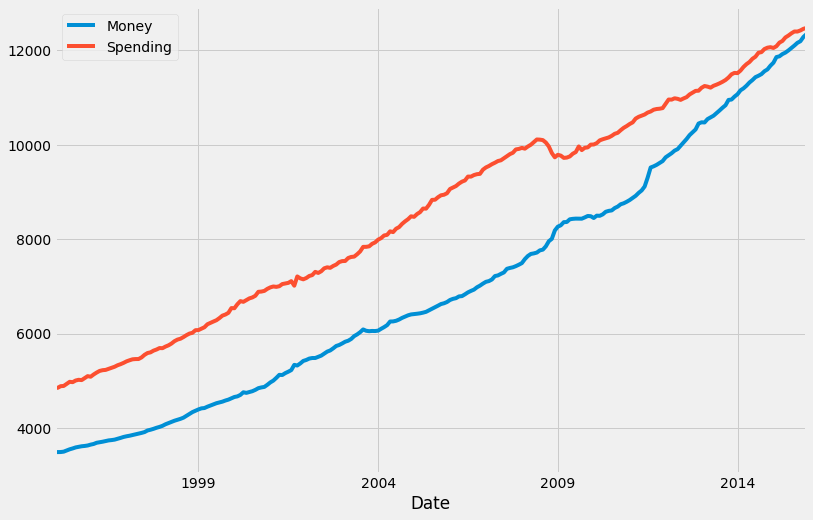

In [48]:
df.plot(figsize = (12,8))

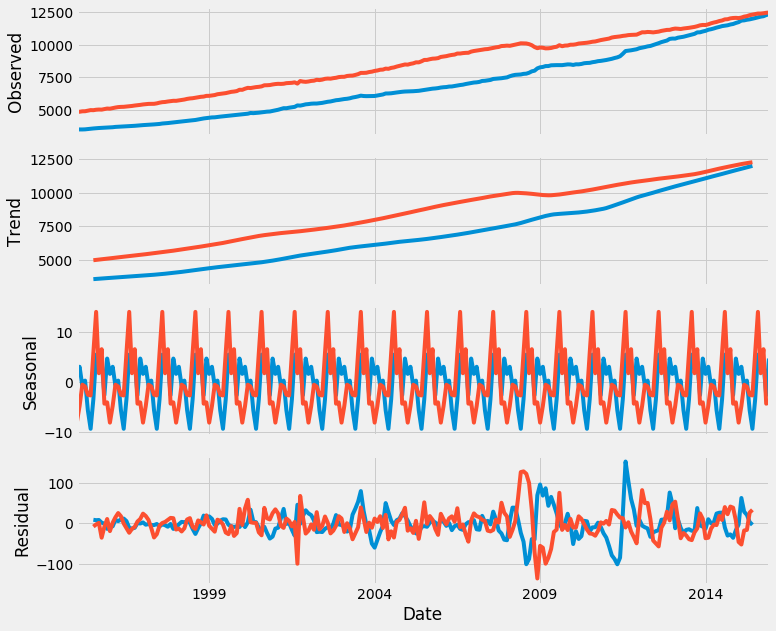

In [49]:
# Statsmodels provides seasonal_decompose function to perform seasonal decomposition
# out of the box
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 11,9

decomposition = sm.tsa.seasonal_decompose(df, model = 'additive')
fig = decomposition.plot()
plt.show()

In [50]:
# Now we have to check for stationarity : 
# We can do that by performing the adf test ;

# Creating a function for adf test : 
def adf_test(series, title = ''): 
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test : {title}')
    result = adfuller(series.dropna(), autolag = 'AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# of observations']
    out = pd.Series(result[0:4], index = labels)
    
    for key, val in result[4].items():
        out[f'critical value({key})'] = val
    print(out.to_string())          # .to_string() removes the line 'dtype : float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('Reject the null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root and is non- stationary')

In [51]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test : 
ADF test statistic       4.239022
p-value                  1.000000
# lags used              4.000000
# of observations      247.000000
critical value(1%)      -3.457105
critical value(5%)      -2.873314
critical value(10%)     -2.573044
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non- stationary


In [52]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test : 
ADF test statistic       0.149796
p-value                  0.969301
# lags used              3.000000
# of observations      248.000000
critical value(1%)      -3.456996
critical value(5%)      -2.873266
critical value(10%)     -2.573019
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non- stationary


In [54]:
# Since both the data are non stationary we have to difference them. Luckily pandas has the feature
# inbuilt into it :

df_transformed = df.diff()

In [55]:
# passing the data obtained through ADF test : 

adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test : 
ADF test statistic      -2.057404
p-value                  0.261984
# lags used             15.000000
# of observations      235.000000
critical value(1%)      -3.458487
critical value(5%)      -2.873919
critical value(10%)     -2.573367
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non- stationary


In [56]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test : 
ADF test statistic    -7.226974e+00
p-value                2.041027e-10
# lags used            2.000000e+00
# of observations      2.480000e+02
critical value(1%)    -3.456996e+00
critical value(5%)    -2.873266e+00
critical value(10%)   -2.573019e+00
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [58]:
# Now Spending is stationary but Money is not stationary yet. So we have to apply another pass of 
# differencing on it. 
# Note : Each time you differenciate the data you lose one row od data (top row)
# since we're losing 1 row from money after 2nd differentiation, the corresponding data in Spending
# can't be used as well. So we apply the differentiation to both the columns

df_transformed = df_transformed.diff()

In [59]:
df_transformed.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,NaN,NaN
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1


In [60]:
df_transformed = df_transformed.dropna()

In [61]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [62]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test : 
ADF test statistic    -7.077471e+00
p-value                4.760675e-10
# lags used            1.400000e+01
# of observations      2.350000e+02
critical value(1%)    -3.458487e+00
critical value(5%)    -2.873919e+00
critical value(10%)   -2.573367e+00
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [63]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test : 
ADF test statistic    -8.760145e+00
p-value                2.687900e-14
# lags used            8.000000e+00
# of observations      2.410000e+02
critical value(1%)    -3.457779e+00
critical value(5%)    -2.873609e+00
critical value(10%)   -2.573202e+00
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [64]:
# Now both the datas are stationary 
df_transformed.shape

(250, 2)

In [65]:
# Splitting the data into training and testing dataset : 
n_obs = 12

In [67]:
train = df_transformed[:-n_obs]

In [68]:
test = df_transformed[-n_obs:]

In [69]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [70]:
# Grid Search for finding order p AR of VAR model : 

model = VAR(train)

for p in range(8):
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 0
AIC: 14.74710921809045


ORDER 1
AIC: 14.178610495220896


ORDER 2
AIC: 13.955189367163705


ORDER 3
AIC: 13.849518291541038


ORDER 4
AIC: 13.827950574458283


ORDER 5
AIC: 13.78730034460964


ORDER 6
AIC: 13.799076756885809


ORDER 7
AIC: 13.797638727913972




In [71]:
# Here order 5 has the lowest AIC value,but you can also take order 3 as it is very close to order 5's
# AIC value. But we take p = 5 here

results = model.fit(5)

In [72]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Oct, 2019
Time:                     14:05:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [73]:
# grab 5 lagged values, right before the test starts
# Numpy array

lagged_values = train.values[-5:]

In [75]:
z = results.forecast(y = lagged_values, steps = 12)

In [76]:
# These results are from the 2nd order differntiation so they dont make much sense here

In [77]:
idx = pd.date_range('2015-01-01', periods = 12, freq = 'MS')

In [78]:
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [79]:
df_forecast = pd.DataFrame(data = z, index = idx, columns = ['Money_2d', 'Spending_2d'])

In [80]:
df_forecast

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [81]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [84]:
# Invert the transformation

# For money column : 

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-n_obs-1]-df['Money'].iloc[-n_obs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-n_obs-1] + df_forecast['Money1d'].cumsum()

In [85]:
# For Spending column : 

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-n_obs-1]-df['Spending'].iloc[-n_obs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-n_obs-1] + df_forecast['Spending1d'].cumsum()

In [86]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [88]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [89]:
test_range = df[-n_obs:]

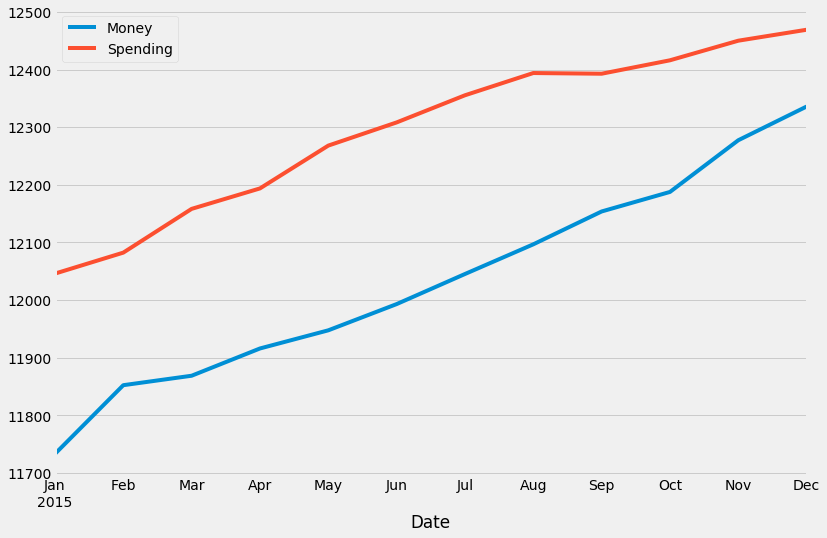

In [90]:
test_range.plot(figsize = (12, 8))

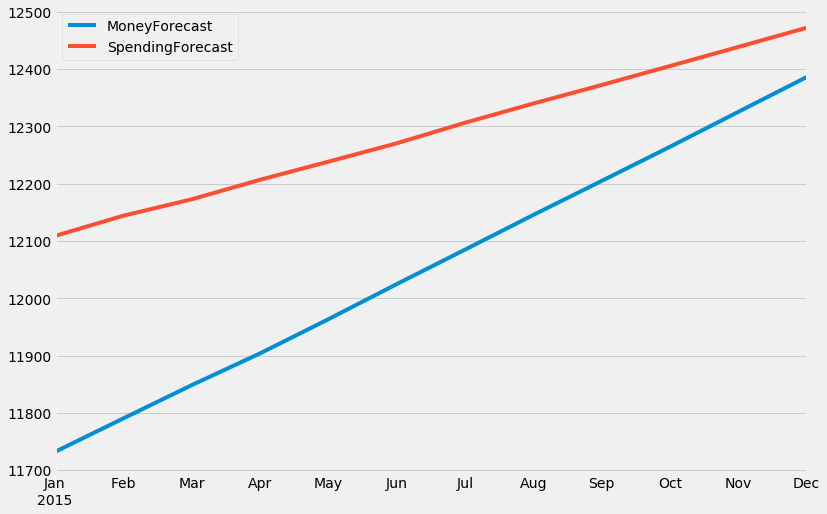

In [91]:
df_forecast[['MoneyForecast', 'SpendingForecast']].plot(figsize = (12,8))

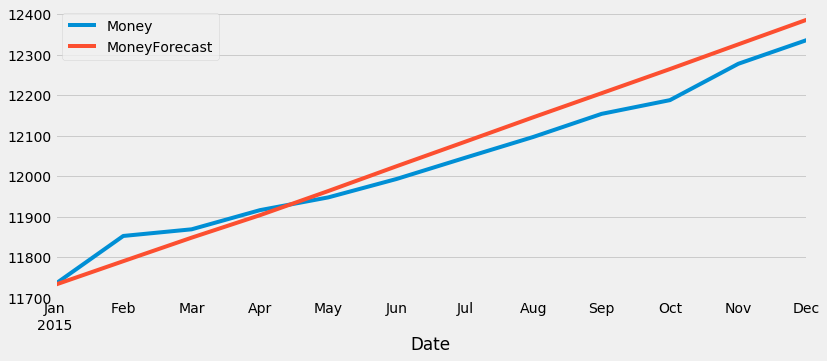

In [92]:
df['Money'][-n_obs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

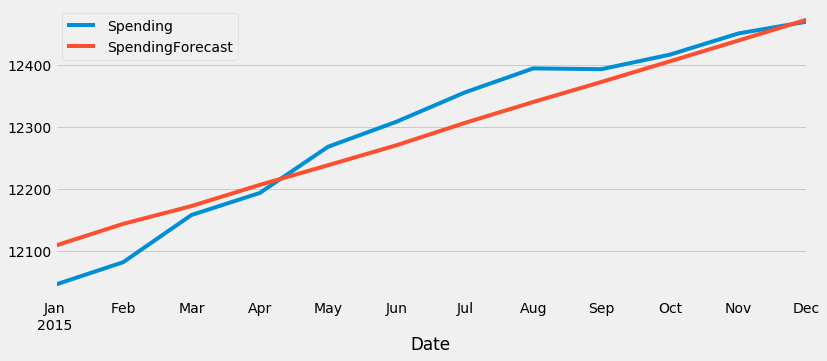

In [94]:
df['Spending'][-n_obs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

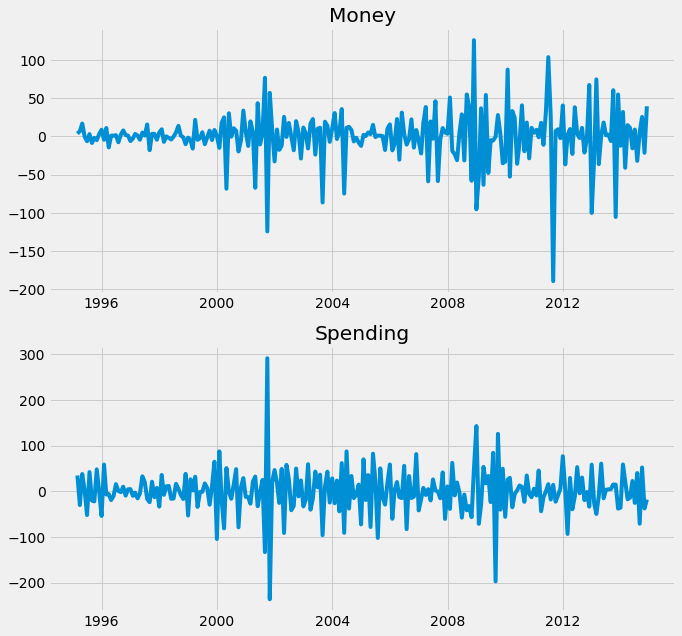

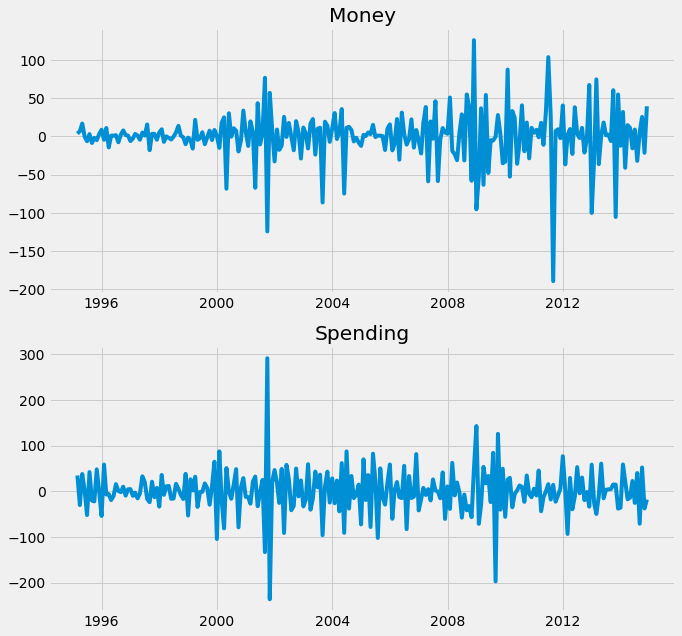

In [101]:
results.plot()

In [97]:
# RMSE 

RMSE1 = rmse(df['Money'][-n_obs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 43.710


In [98]:
RMSE2 = rmse(df['Spending'][-n_obs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 37.001
